In [3]:
from typing import Dict, Tuple
import scipy.io as sio
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
import rasterio
from rasterio.plot import show
from PIL import Image
import os
import skimage as ski
from skimage import io
import keras
from keras import layers
import tensorflow as tf
io.use_plugin('pil')

In [4]:
def normalize_images(images):
    min_value = np.min(images)
    max_value = np.max(images)
    normalized_images = (images - min_value) / (max_value - min_value)
    return normalized_images


In [5]:

def normalize_gray_images(images):
    mean = images.mean()
    std = images.std()
    normalized_images = (images - mean) / std

    return normalized_images


In [6]:
def subsample(img, k):
    lst = []
    for i in range(0,img.shape[0]):
        x = img[i][::k, ::k]
        lst.append(x.T)
    return np.array(lst)

In [7]:
dataset = []

folder_path = "//home//rounak//Desktop//KN//"
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.tiff'))]
k=0
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    if(k%100==0):
        print(k)
    k+=1
    img_push = np.zeros((323,323,3))
    img = io.imread(image_path, plugin='pil')
    img = np.array(img)
    img_push[:,:,0] = normalize_images(img[:,:,0])
    img_push[:,:,1] = normalize_images(img[:,:,2])
    img_push[:,:,2] = 0.5*normalize_images(img[:,:,0])+0.5*normalize_images(img[:,:,2])
    img_push = np.array(img_push)
    image_array = img_push.T
    tensor = torch.from_numpy(image_array)
    tensor = normalize_images(np.array(tensor))
    tensor = 2*tensor - 1
    '''mean_1, std_1 = tensor[0,:,:].mean(), tensor[0,:,:].std()
    mean_2, std_2 = tensor[1,:,:].mean(), tensor[1,:,:].std()
    mean_3, std_3 = tensor[2,:,:].mean(), tensor[2,:,:].std()
    norm = transforms.Normalize((mean_1, mean_2, mean_3), (std_1, std_2, std_3))
    tensor = norm(tensor)'''
    #image_array = torch.from_numpy(np.array(image_array))
    #norm = transforms.Normalize((0,0,0), (1,1,1), inplace = True)
    #image_array = norm(torch.tensor(image_array))
    dataset.append((tensor,0))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [8]:
dataset_compressed_1 = []

for i in range(5067):
    dataset_compressed_1.append(np.float32(np.array(dataset[i][0].T)))

dataset_compressed_1 = np.array(dataset_compressed_1)

dataset_compressed_1 = subsample(dataset_compressed_1, 1)

dataset_compressed_1 = np.array(dataset_compressed_1)
dataset_compressed_1.shape

(5067, 3, 323, 323)

In [9]:
dataset_compressed_1 = normalize_gray_images(np.float32(np.array(dataset_compressed_1)))
dataset_compressed_1.shape

(5067, 3, 323, 323)

In [10]:
dataset_final_1 = []
for i in range(5067):
    img_arr = dataset_compressed_1[i]
    img_arr = img_arr[:, :320, :320]
    dataset_final_1.append((torch.from_numpy(img_arr),0))

In [11]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device="cuda:1"):
        super(DownBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [12]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, flag = 1, device="cuda:1"):
        super(UpBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        if(flag == 1):
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose2d(out_channels, out_channels, 2, 2),
            )
        else:
            self.model = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, 1, 1),
                nn.ReLU()
            )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels_):
        super(AutoEncoder, self).__init__()
        self.in_channels_ = in_channels_
        layers_1 = [
            DownBlock(in_channels=in_channels_, out_channels=16),
            DownBlock(16, 8),
        ]
        layers_2 = [
            UpBlock(in_channels = 8, out_channels = 16),
            UpBlock(in_channels = 16, out_channels = 16),
            UpBlock(16, in_channels_, 2)
        ]
        layers = [*layers_1, *layers_2]
        self.model = nn.Sequential(*layers)
        self.model_decode = nn.Sequential(*layers_1)
        self.model_encode = nn.Sequential(*layers_2)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    def decode(self, x:torch.Tensor) -> torch.Tensor:
        return self.model_decode(x)
    def encode(self, x:torch.Tensor) -> torch.Tensor:
        return self.model_encode(x)

In [17]:
auto_encoder = AutoEncoder(3).to("cuda:1")
dataloader = DataLoader(dataset_final_1, batch_size=128, shuffle=True)
optim = torch.optim.Adam(auto_encoder.parameters(), lr=1e-4)

In [18]:
import os
auto_encoder.train()
loss_lst=[]
loss_val = 0
for ep in range(0, 100):
    print("allocated mem -", torch.cuda.memory_allocated(torch.device("cuda:1")) * 1e-9)
    print("epoch number: ", ep)
    optim.param_groups[0]['lr'] = 1e-4
    pbar = tqdm(dataloader, mininterval = 2)
    loss_val = 0
    for x,_ in pbar:
        optim.zero_grad()
        x=x.to("cuda:1")
        pred_x = auto_encoder(x)
        loss = F.mse_loss(pred_x, x)
        loss_val += loss
        loss.backward()
        optim.step()
    loss_lst.append(loss_val)

allocated mem - 0.315051008
epoch number:  0


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.43it/s]


allocated mem - 0.276617728
epoch number:  1


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.27661824
epoch number:  2


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.72it/s]


allocated mem - 0.276618752
epoch number:  3


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.68it/s]


allocated mem - 0.27661926400000003
epoch number:  4


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


allocated mem - 0.27661977600000004
epoch number:  5


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.65it/s]


allocated mem - 0.276620288
epoch number:  6


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.2766208
epoch number:  7


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.39it/s]


allocated mem - 0.276621312
epoch number:  8


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276621824
epoch number:  9


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276622336
epoch number:  10


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.56it/s]


allocated mem - 0.27662284800000003
epoch number:  11


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.27662336000000004
epoch number:  12


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276623872
epoch number:  13


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


allocated mem - 0.276624384
epoch number:  14


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276624896
epoch number:  15


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.276625408
epoch number:  16


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.27662592
epoch number:  17


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.53it/s]


allocated mem - 0.27662643200000003
epoch number:  18


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


allocated mem - 0.27662694400000004
epoch number:  19


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


allocated mem - 0.276627456
epoch number:  20


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


allocated mem - 0.276627968
epoch number:  21


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


allocated mem - 0.27662848
epoch number:  22


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.66it/s]


allocated mem - 0.276628992
epoch number:  23


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276629504
epoch number:  24


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.27663001600000003
epoch number:  25


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


allocated mem - 0.27663052800000004
epoch number:  26


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.27663104
epoch number:  27


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.276631552
epoch number:  28


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


allocated mem - 0.276632064
epoch number:  29


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


allocated mem - 0.276632576
epoch number:  30


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.51it/s]


allocated mem - 0.276633088
epoch number:  31


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.27663360000000004
epoch number:  32


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.27663411200000004
epoch number:  33


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


allocated mem - 0.276634624
epoch number:  34


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276635136
epoch number:  35


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276635648
epoch number:  36


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.27663616
epoch number:  37


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.27663667200000003
epoch number:  38


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.27663718400000004
epoch number:  39


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


allocated mem - 0.27663769600000004
epoch number:  40


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


allocated mem - 0.276638208
epoch number:  41


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.27663872
epoch number:  42


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.64it/s]


allocated mem - 0.276639232
epoch number:  43


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.276639744
epoch number:  44


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.27664025600000003
epoch number:  45


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.27664076800000004
epoch number:  46


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.27664128000000004
epoch number:  47


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.276641792
epoch number:  48


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.276642304
epoch number:  49


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.276642816
epoch number:  50


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.276643328
epoch number:  51


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.27664384000000003
epoch number:  52


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.45it/s]


allocated mem - 0.27664435200000004
epoch number:  53


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.276644864
epoch number:  54


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.276645376
epoch number:  55


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276645888
epoch number:  56


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.54it/s]


allocated mem - 0.2766464
epoch number:  57


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.276646912
epoch number:  58


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.27664742400000003
epoch number:  59


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.27664793600000004
epoch number:  60


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276648448
epoch number:  61


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.27664896
epoch number:  62


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


allocated mem - 0.276649472
epoch number:  63


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.63it/s]


allocated mem - 0.276649984
epoch number:  64


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276650496
epoch number:  65


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.27665100800000003
epoch number:  66


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.27665152000000004
epoch number:  67


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.276652032
epoch number:  68


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.276652544
epoch number:  69


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.56it/s]


allocated mem - 0.276653056
epoch number:  70


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.276653568
epoch number:  71


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.27665408
epoch number:  72


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.62it/s]


allocated mem - 0.27665459200000003
epoch number:  73


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.27665510400000004
epoch number:  74


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.60it/s]


allocated mem - 0.276655616
epoch number:  75


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276656128
epoch number:  76


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.27665664
epoch number:  77


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276657152
epoch number:  78


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276657664
epoch number:  79


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.47it/s]


allocated mem - 0.27665817600000003
epoch number:  80


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.27665868800000004
epoch number:  81


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.2766592
epoch number:  82


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276659712
epoch number:  83


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.51it/s]


allocated mem - 0.276660224
epoch number:  84


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276660736
epoch number:  85


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276661248
epoch number:  86


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.61it/s]


allocated mem - 0.27666176000000003
epoch number:  87


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.59it/s]


allocated mem - 0.27666227200000004
epoch number:  88


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.276662784
epoch number:  89


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.276663296
epoch number:  90


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276663808
epoch number:  91


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.27666432
epoch number:  92


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276664832
epoch number:  93


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.27666534400000004
epoch number:  94


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.27666585600000004
epoch number:  95


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.54it/s]


allocated mem - 0.276666368
epoch number:  96


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.54it/s]


allocated mem - 0.27666688
epoch number:  97


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.58it/s]


allocated mem - 0.276667392
epoch number:  98


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


allocated mem - 0.276667904
epoch number:  99


100%|███████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


In [ ]:
plt.plot(torch.Tensor(loss_lst).cpu().data.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 320, 320)

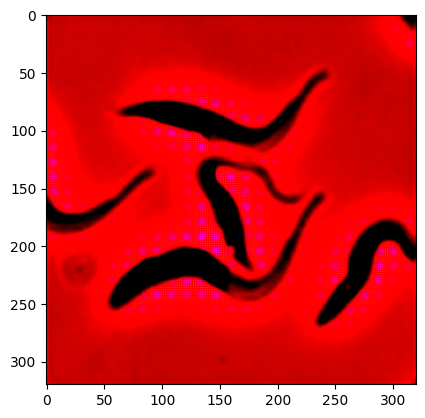

In [19]:
x = auto_encoder(torch.Tensor(dataset_final_1[2][0]).to("cuda:1"))
x = x.cpu().data.numpy()
x = np.array(x)
plt.imshow(x.T)
x.shape

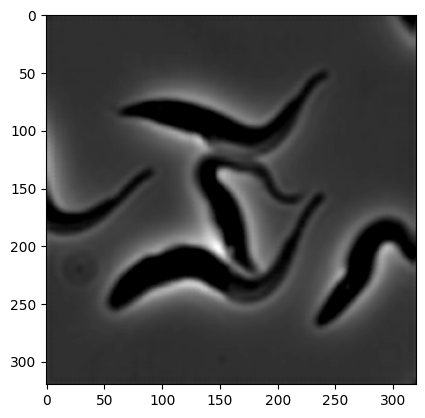

In [31]:
np.linalg.norm(x[0]-np.zeros((320,320)))
image = np.zeros((1,320,320))
image = np.expand_dims(x[0], axis=0)
plt.imshow(image.T, cmap="gray")

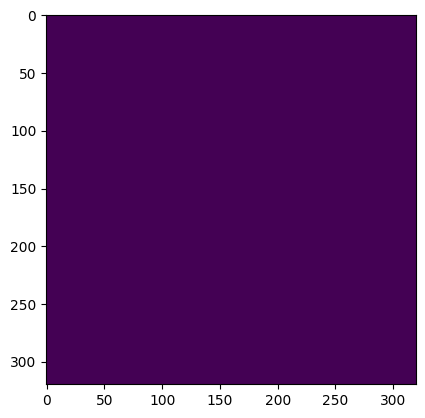

In [42]:
image_1 = np.zeros((1,320,320))
for i in range(320):
    for j in range(320):
        if(image[0,i,j]>1.02):
            image_1[0][i][j] = 0 
        else:
            image_1[0][i][j] = 1
plt.imshow(image_1.T)

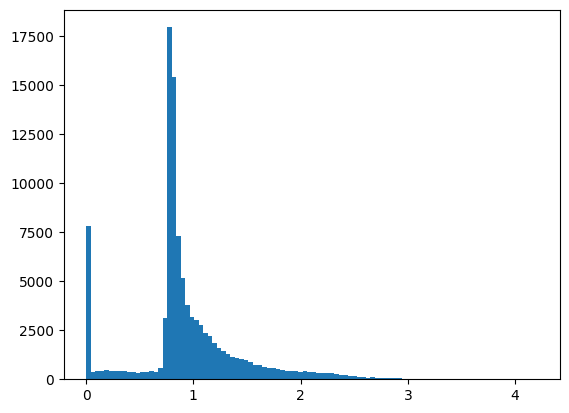

In [34]:
plt.hist(np.reshape(image, -1), bins=100)
plt.show()

(80, 80)

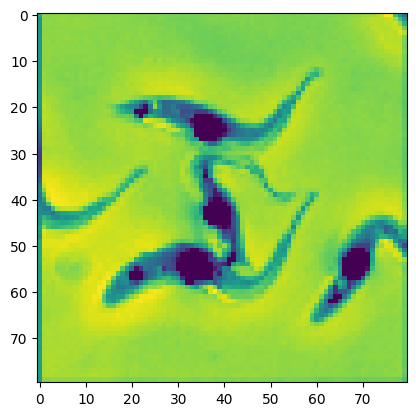

In [19]:
x = auto_encoder.decode(torch.Tensor(dataset_final_1[2][0]).to("cuda:1"))
x = x.cpu().data.numpy()
x = np.array(x)
x = x[2,:,:]
plt.imshow(x.T)
x.shape

In [20]:
dataset_decoded = []
for i in range(5067):
    x = auto_encoder.decode(torch.Tensor(dataset_final_1[i][0]).to("cuda:1"))
    x = x.cpu().data.numpy()
    x = np.array(x)
    dataset_decoded.append(np.float32(x))
dataset_decoded = np.array(dataset_decoded)
dataset_decoded.shape

(5067, 32, 80, 80)

In [21]:
dataset_final_decoded = []
for i in range(5067):
    img_arr = dataset_decoded[i]
    dataset_final_decoded.append((torch.from_numpy(img_arr),0))

In [22]:
dataset_final_decoded[0][0].shape

torch.Size([32, 80, 80])

In [23]:
x = torch.Tensor(dataset_decoded[0]).to("cuda:1")
x = auto_encoder.encode(torch.Tensor(x))
x.shape

torch.Size([3, 320, 320])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


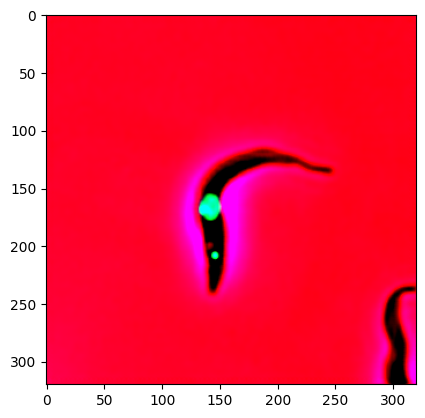

In [24]:
plt.imshow(x.cpu().data.numpy().T)

In [5]:
def stochastic_mixer(img1, img2, t, k):
    noise_1 = torch.randn_like(img1)
    noise_2 = torch.randn_like(img2)
    img1_encode = perturb_input(img1, t, noise_1)
    img2_encode = perturb_input(img2, t, noise_2)
    img1_vec = np.reshape(img1, (-1, 1))
    img2_vec = np.reshape(img2, (-1, 1))
    theta = np.arccos(np.matmul(img1_vec.T, img2_vec))/np.linalg.norm(img1_vec)*np.linalg.norm(img2_vec)
    img_inter_ddim = np.sin(k*theta)/np.sin(theta)*img1_encode + np.sin((1-k)*theta)/np.sin(theta)*img2_encode
    return img_inter_ddim       # create other dot products
    

def interpolator(img1, img2, t_1 = timesteps*0.7, k=0.5):
    sample = stochastic_mixer(img1, img2, t, k)
    t = torch.tensor(t_1 / timesteps).to(device)
    z = torch.randn_like(sample) if i > 1 else 0
    eps = nn_model(samples, t)
    sample = denoise_add_noise(sample, t_1, eps, z)
    return sample

def image_value(img):
    value=0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            value+=img[i][j]
    return value

NameError: name 'timesteps' is not defined

In [10]:
dataset_compressed = []

for i in range(5067):
    dataset_compressed.append(np.float32(np.array(dataset[i][0].T)))

dataset_compressed = np.array(dataset_compressed)

dataset_compressed = subsample(dataset_compressed, 4)

dataset_compressed = np.array(dataset_compressed)
dataset_compressed.shape

(5067, 3, 81, 81)

In [11]:
dataset_compressed = normalize_gray_images(np.float32(np.array(dataset_compressed)))
dataset_compressed.shape


(5067, 3, 81, 81)

In [12]:
dataset_final = []
for i in range(5067):
    img_arr = dataset_compressed[i]
    img_arr = img_arr[:, :80, :80]
    dataset_final.append((torch.from_numpy(img_arr),0))


In [52]:
dataset_final_1[0][0].shape

torch.Size([3, 320, 320])

In [51]:
plt.imshow(dataset_final[1][0].T)

NameError: name 'dataset_final' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


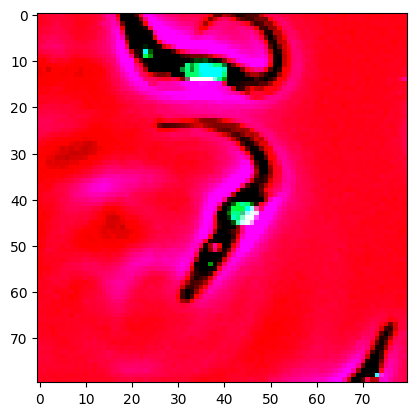

In [14]:
plt.imshow(dataset_final[40][0].T, cmap="gray")

In [15]:
lst_img = []

for i in range(50):
    lst_img.append(np.array(dataset[i][0].T))

lst_img = np.array(lst_img)

In [17]:
lst_of_img_reduced = []
loss_lst = []

lst_of_img_damn = None
for i in range(1,30):
    loss_lst.append(0)
for k in range(1,30):
    lst_of_img_damn = subsample(lst_img, k)
    latest_img = torch.from_numpy(lst_of_img_damn).float()
    img_interpolated = F.interpolate(latest_img,(323,323), mode='bilinear')
    for i in range(dataset[0][0].shape[0]):
        img = lst_img[i]
        img_int = img_interpolated[i].T
        diff_img = np.array(img)- np.array(img_int)
        loss_lst[k-1]+=(np.linalg.norm(diff_img))

[2.24391251e-05 2.05294446e+01 3.58241157e+01 5.63110584e+01
 6.35083211e+01 9.57538384e+01 8.27760217e+01 9.17568271e+01
 1.46519277e+02 1.10429324e+02 1.22690244e+02 1.81582643e+02
 1.81416827e+02 1.53101674e+02 1.72457253e+02 1.65360604e+02
 2.35410568e+02 2.41415553e+02 2.53441367e+02 1.95171239e+02
 2.10294853e+02 2.37167219e+02 2.18104056e+02 2.27944067e+02
 2.74460192e+02 2.42806607e+02 2.62515772e+02 2.44525516e+02
 2.45035911e+02]


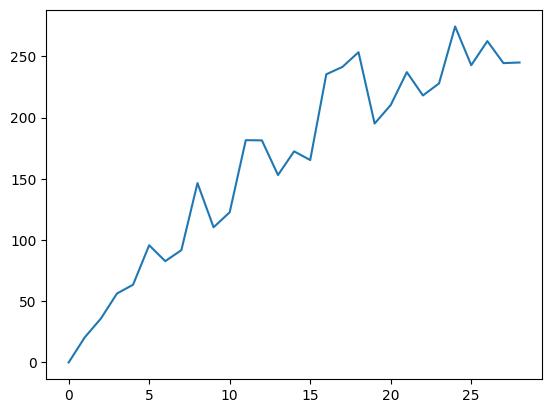

In [19]:
print(np.array(loss_lst))
plt.plot(loss_lst)

In [20]:
dataset_compressed = []

for i in range(5067):
    dataset_compressed.append(np.float32(np.array(dataset[i][0].T)))
    if(i%100==0):
        print(i)
dataset_compressed = np.array(dataset_compressed)

dataset_compressed = subsample(dataset_compressed, 4)

dataset_compressed = np.array(dataset_compressed)

dataset_compressed.shape

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


(5067, 3, 81, 81)

In [16]:
dataset_compressed = normalize_images(np.float32(np.array(dataset_compressed)))
dataset_compressed.shape

(5067, 3, 81, 81)

In [17]:
dataset_final = []
for i in range(5067):
    img_arr = dataset_compressed[i]
    img_arr = img_arr[:, :80, :80]
    dataset_final.append((torch.from_numpy(img_arr),0))


In [25]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels), 
            nn.GELU(), 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:  
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [26]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels), 
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        return self.model(torch.cat((x, skip), 1))


In [27]:

class EmbedFC(nn.Module):
    def __init__(self, input_dim , emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim).to(device)
        return self.model(x)

In [48]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 2, 2), 
            nn.GroupNorm(8, 2 * n_feat),                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [50]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 4*n_feat)
        self.timeembed2 = EmbedFC(1, 2*n_feat)
        self.timeembed3 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, 2, 2),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        hiddenvec = self.to_vec(down3)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down3)
        up3 = self.up2(cemb2*up2 + temb2, down2)
        up4 = self.up3(cemb3*up3 + temb3, down1)
        out = self.out(torch.cat((up4, x), 1))
        return out


In [51]:
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02


device="cuda:1"
n_feat = 128
n_cfeat = 10 
height = 80
save_dir = './weight_nn_decoded/'

batch_size = 128
n_epoch = 5000
lrate=1e-3

In [52]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [21]:
s=0.008
f = (torch.cos((torch.linspace(0, timesteps, timesteps + 1)/timesteps+s)/(1+s) * torch.asin(torch.tensor(1))))**2
ab_t = f/(torch.cos((s)/(1+s) * torch.asin(torch.tensor(1))))**2
b_t = []
for i in range(1, timesteps):
    b_t.append(1-ab_t[i]/ab_t[i-1])
b_t = torch.tensor(b_t)
a_t = 1 - b_t
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [53]:
@torch.no_grad()
def sample_ddpm_context(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 32, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [54]:
nn_model = ContextUnet(in_channels=32, n_feat=n_feat, n_cfeat=n_cfeat).to(device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [55]:
dataloader = DataLoader(dataset_final_decoded, batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [56]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise, device=device):
    final = ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise
    final = final.to(device)
    return final

In [57]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [58]:
# define sampling function for DDIM   
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]
    
    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [59]:
# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 32, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [60]:
def make_encoding(x, n_samples=batch_size, n_classes=n_cfeat):
    encode = [
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
    ]
    final = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        final[i] = encode[x[i].int()]
    final = torch.tensor(final).float().to(device)
    return final

In [61]:
loss_train  = []

In [62]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
    plt.show()

In [63]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

0.0

In [34]:
checkpoint = torch.load(f"{save_dir}nn_model_tryptag6420.pth", map_location = device)
epoch = checkpoint['epoch']
optim.load_state_dict(checkpoint['optimizer_state_dict'])
nn_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [35]:
loss_values_1 = []
epoch=0

In [47]:
#sio.savemat("losses_colored.mat", {"loss": loss_values_1})
losses_list = sio.loadmat("losses_colored.mat")["loss"][0].tolist()
loss_values_1 = losses_list
losses_list

[1.145786166191101,
 1.224131464958191,
 1.1024025678634644,
 0.8954920768737793,
 0.8134700059890747,
 0.721552848815918,
 0.7527568936347961,
 0.6437762975692749,
 0.5956993699073792,
 0.5834311246871948,
 0.5272763967514038,
 0.5189197063446045,
 0.4295951724052429,
 0.42392048239707947,
 0.35207968950271606,
 0.3728736340999603,
 0.31271758675575256,
 0.45025384426116943,
 0.3415336012840271,
 0.3545990288257599,
 0.34924113750457764,
 0.38385599851608276,
 0.3301984965801239,
 0.3027195632457733,
 0.2774387300014496,
 0.36543041467666626,
 0.3589394986629486,
 0.3151460886001587,
 0.24394257366657257,
 0.3327803313732147,
 0.25153663754463196,
 0.3570013642311096,
 0.2795880138874054,
 0.2507716715335846,
 0.24015845358371735,
 0.2478528618812561,
 0.31702902913093567,
 0.1710890680551529,
 0.26615792512893677,
 0.21728597581386566,
 0.21172188222408295,
 0.27311134338378906,
 0.3186182379722595,
 0.2063940316438675,
 0.3080774247646332,
 0.17371061444282532,
 0.2615916430950165,


In [ ]:
import os
nn_model.train()

lmin=1e10

for ep in range(0, n_epoch*2):
    print("allocated mem -", torch.cuda.memory_allocated(torch.device("cuda:1")) * 1e-9)
    print("epoch number: ", ep)
    optim.param_groups[0]['lr'] = lrate*(1-0.2*ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    #print(pbar)
    #break
    #k=0
    loss_val = 0
    for x,_ in pbar:
        optim.zero_grad()
        x=x.to(device)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise = nn_model(x_pert, t/timesteps)
        loss = F.mse_loss(pred_noise, noise)
        #loss_values_1.append(loss.item())
        loss_val+=loss
        loss.backward()
        optim.step()
    if (loss_val < lmin):
        lmin = loss_val
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
        }, str(save_dir+f"nn_model_tryptag_decoded_best.pth"))
    if(ep%20==0):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
            }, str(save_dir+f"nn_model_decoded_tryptag{ep}.pth"))
        print("Saved model at " + str(save_dir+f"nn_model_tryptag_decoded.pth"))
        with torch.no_grad():
                xh,_ = sample_ddpm_context(8)
                x_encoded = []
                for i in range(8):
                    x_encoded.append(auto_encoder.encode(xh[i]).cpu().data.numpy())
                x_encoded = torch.from_numpy(np.array(x_encoded)).to("cuda:1")
                x_encoded_1 = []
                for i in range(8):
                    x_encoded_1.append(auto_encoder.encode(x[i]).cpu().data.numpy())
                x_encoded_1 = torch.from_numpy(np.array(x_encoded_1)).to("cuda:1")
                print(x[:8].shape)
                print(x_encoded.shape)
                xset = torch.cat([x_encoded, x_encoded_1], dim=0)
                grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
                save_image(grid, str(save_dir+f"ddpm_sample_tryptag_colored_decoded_better{ep}.png"))

allocated mem - 0.5779430400000001
epoch number:  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


Saved model at ./weight_nn_decoded/nn_model_tryptag_decoded.pth
torch.Size([8, 32, 80, 80])
torch.Size([8, 3, 320, 320])
allocated mem - 0.7916794880000001
epoch number:  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7916794880000001
epoch number:  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7916794880000001
epoch number:  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7916794880000001
epoch number:  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7916794880000001
epoch number:  5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7916794880000001
epoch number:  6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7916794880000001
epoch number:  7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7916794880000001
epoch number:  8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7916794880000001
epoch number:  9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7916794880000001
epoch number:  10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.94it/s]


allocated mem - 0.7916794880000001
epoch number:  11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.94it/s]


allocated mem - 0.7916794880000001
epoch number:  12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.95it/s]


allocated mem - 0.7916794880000001
epoch number:  13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.94it/s]


allocated mem - 0.7916794880000001
epoch number:  14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.95it/s]


allocated mem - 0.7916794880000001
epoch number:  15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7916794880000001
epoch number:  16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7916794880000001
epoch number:  17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7916794880000001
epoch number:  18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.99it/s]


allocated mem - 0.7916794880000001
epoch number:  19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7916794880000001
epoch number:  20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


Saved model at ./weight_nn_decoded/nn_model_tryptag_decoded.pth
torch.Size([8, 32, 80, 80])
torch.Size([8, 3, 320, 320])
allocated mem - 0.7916794880000001
epoch number:  21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7908520960000001
epoch number:  22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7917634560000001
epoch number:  23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7922042880000001
epoch number:  24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7917634560000001
epoch number:  25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7908520960000001
epoch number:  26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7917634560000001
epoch number:  27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7908520960000001
epoch number:  28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.793115648
epoch number:  29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7908520960000001
epoch number:  30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7917634560000001
epoch number:  31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7908520960000001
epoch number:  32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7917634560000001
epoch number:  33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7908520960000001
epoch number:  34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.793115648
epoch number:  35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7908520960000001
epoch number:  36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7917634560000001
epoch number:  37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7908520960000001
epoch number:  38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7917634560000001
epoch number:  39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7922042880000001
epoch number:  40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


Saved model at ./weight_nn_decoded/nn_model_tryptag_decoded.pth
torch.Size([8, 32, 80, 80])
torch.Size([8, 3, 320, 320])
allocated mem - 0.7933701120000001
epoch number:  41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7925340160000001
epoch number:  42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7926574080000001
epoch number:  43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7942635520000001
epoch number:  44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7946158080000001
epoch number:  45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7929113600000001
epoch number:  46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7946158080000001
epoch number:  47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7929113600000001
epoch number:  48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7946158080000001
epoch number:  49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7929113600000001
epoch number:  50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7946158080000001
epoch number:  51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7942635520000001
epoch number:  52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7932636160000001
epoch number:  53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7942635520000001
epoch number:  54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7946158080000001
epoch number:  55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.96it/s]


allocated mem - 0.7942635520000001
epoch number:  56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7946158080000001
epoch number:  57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7929113600000001
epoch number:  58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7932636160000001
epoch number:  59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7942635520000001
epoch number:  60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


Saved model at ./weight_nn_decoded/nn_model_tryptag_decoded.pth
torch.Size([8, 32, 80, 80])
torch.Size([8, 3, 320, 320])
allocated mem - 0.794361344
epoch number:  61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.792146432
epoch number:  63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7943178240000001
epoch number:  66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.792146432
epoch number:  67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.97it/s]


allocated mem - 0.7943178240000001
epoch number:  70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.792146432
epoch number:  72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.792965632
epoch number:  74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.792146432
epoch number:  75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.792965632
epoch number:  78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793498624
epoch number:  80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


Saved model at ./weight_nn_decoded/nn_model_tryptag_decoded.pth
torch.Size([8, 32, 80, 80])
torch.Size([8, 3, 320, 320])
allocated mem - 0.793498624
epoch number:  81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7929661440000001
epoch number:  82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7936957440000001
epoch number:  83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7912678400000001
epoch number:  84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7912678400000001
epoch number:  85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7936957440000001
epoch number:  86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.791161344
epoch number:  90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925135360000001
epoch number:  100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


Saved model at ./weight_nn_decoded/nn_model_tryptag_decoded.pth
torch.Size([8, 32, 80, 80])
torch.Size([8, 3, 320, 320])
allocated mem - 0.7925135360000001
epoch number:  101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7935175680000001
epoch number:  102


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793947136
epoch number:  103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793947136
epoch number:  104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7935175680000001
epoch number:  105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7935175680000001
epoch number:  106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793947136
epoch number:  107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7925949440000001
epoch number:  108


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.792165376
epoch number:  109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7935175680000001
epoch number:  110


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793947136
epoch number:  111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.793947136
epoch number:  112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


allocated mem - 0.7935175680000001
epoch number:  113


 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 15/40 [00:07<00:12,  2.00it/s]

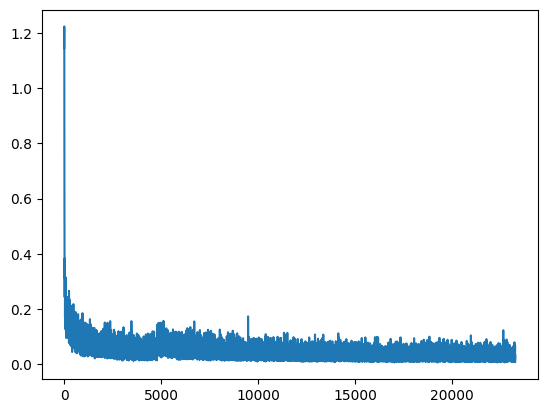

In [47]:
loss_values_1 = torch.tensor(loss_values_1).cpu()
plt.plot(np.array(loss_values_1))
loss_values_1 = loss_values_1.tolist()

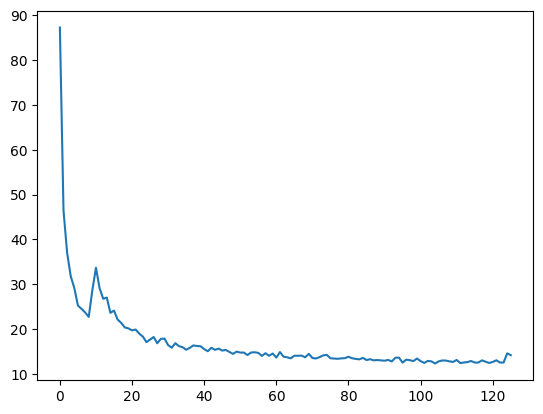

In [84]:
loss_values_1 = np.asarray(loss_values_1)
sum1=0
loss_values_epoch=[]
for i in range(1, loss_values_1.shape[0]):
    sum1+=loss_values_1[i]
    if(i%500==0):
        loss_values_epoch.append(sum1)
        sum1=0
loss_values_epoch = np.asarray(loss_values_epoch)
plt.plot(loss_values_epoch)

In [90]:
loss_values_1.shape

torch.Size([364738])

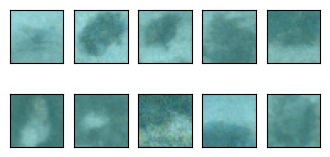

In [88]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
from network import Net

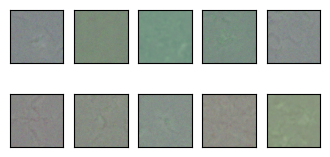

In [50]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0])
show_images(samples)

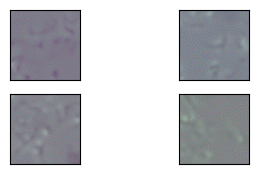

In [93]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(4)
show_images(samples)

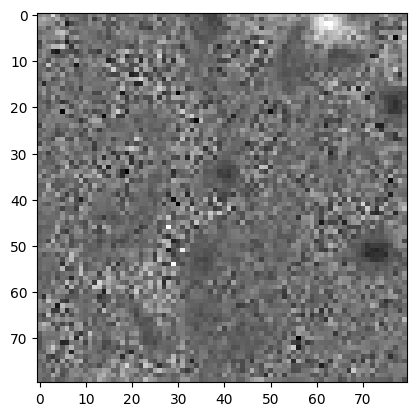

In [96]:
plt.imshow(samples[0][0,:,:].cpu().T, cmap="gray")

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
import os
nn_model.train()
guide_w = 0.3
loss_values_2=[]
for ep in range(n_epoch):
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    for x, c in pbar:
        optim.zero_grad()
        x=x.to(device)
        c=c.to(device)
        c=make_encoding(c)
    #print(c.shape)
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        
    #print(c.shape)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise_2 = nn_model(x_pert, t/timesteps, c=None)
        pred_noise_1 = nn_model(x_pert, t/timesteps, c)
        pred_noise_final = eps = (1+guide_w)*pred_noise_1 - guide_w*pred_noise_2
        loss = F.mse_loss(pred_noise_final, noise)
        loss_values_2.append(loss)
        loss.backward()
        optim.step()
    

In [ ]:
loss_values_2 = torch.tensor(loss_values_2).cpu()
plt.plot(np.array(loss_values_2)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], None)
show_images(samples)

In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
#animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
#HTML(animation_ddpm_context.to_jshtml())